In [2]:
using DataFrames, DataFramesMeta, JSON, Statistics
using StatsPlots
using GLM
gr()

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278


Plots.GRBackend()

In [9]:
data = []
for fname in readdir()
    name, ext = splitext(fname)
    if ext == ".json"
        fields = split(fname, '_')
        if fields[1] == "poisson" || fields[1] == "constant"
            j = JSON.parsefile(fname; dicttype=Dict, inttype=Int64)
            push!(data, (fields, j, name))
        end
    end
end

In [10]:
df = DataFrame(
    name = String[],
    arrival_type = String[],
    arrival_rate = Int[],
    vehicles = Int[],
    time_windows = Int[],
    locations = Int[],
    policy = String[],
    day = Int[],
    packages = Int[],
    avg_days_taken = Float64[],
    total_distance = Int[],
    total_time = Int[],
    deliveries = Int[],
    attempted_deliveries = Int[]
)
for v in data
    for record in v[2]
        push!(df, (
            v[3],
            v[1][1],
            parse(Int, v[1][2]),
            parse(Int, v[1][3]),
            parse(Int, v[1][4]),
            parse(Int, v[1][5]),
            v[1][6],
            record["day"],
            record["number_of_packages"],
            mean(record["delivered_packages"]["days_taken"]),
            sum(record["distances"]),
            sum(record["times"]),
            length(record["delivered_packages"]["days_taken"]),
            sum(record["deliveries_attempted"]),
        ))
    end
end
df

,name,arrival_type,arrival_rate,vehicles,time_windows
,String,String,Int64,Int64,Int64
1,constant_50_3_1_1_calling_policy,constant,50,3,1
2,constant_50_3_1_1_calling_policy,constant,50,3,1
3,constant_50_3_1_1_calling_policy,constant,50,3,1
4,constant_50_3_1_1_calling_policy,constant,50,3,1
5,constant_50_3_1_1_calling_policy,constant,50,3,1
6,constant_50_3_1_1_calling_policy,constant,50,3,1
7,constant_50_3_1_1_calling_policy,constant,50,3,1
8,constant_50_3_1_1_calling_policy,constant,50,3,1
9,constant_50_3_1_1_calling_policy,constant,50,3,1


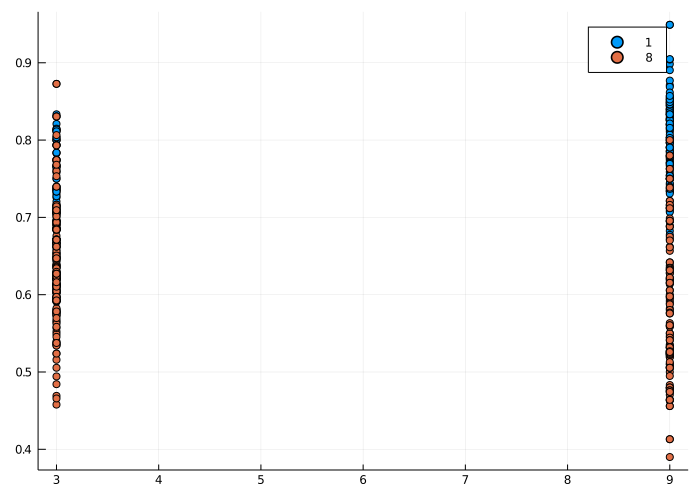

In [11]:
gr(size=(700,500))

@df (@linq df |> 
    where(:locations .== 2)
) scatter(
    :vehicles, :deliveries ./ :attempted_deliveries, group = :time_windows
)

Number of deliveries by locations


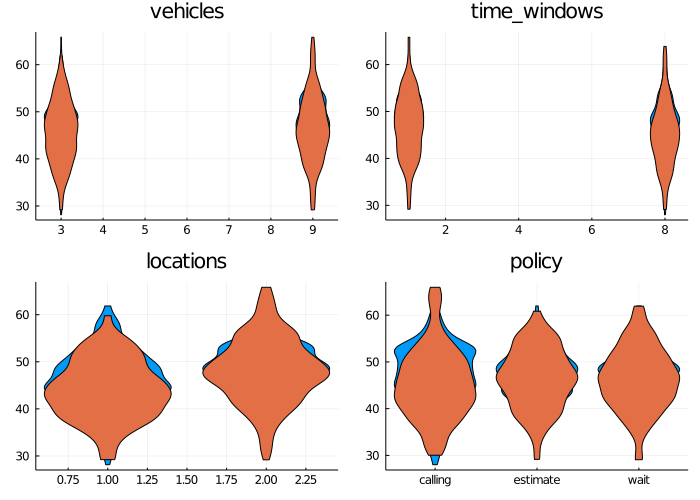

In [14]:
q = @linq df |>
    #where(:day .> 10) |>
    #by([:vehicles, :time_windows, :locations, :policy], y = mean(:deliveries)) |>
    where(:vehicles .> 0) |>
    where(:time_windows .> 0) |>
    where(:locations .> 0)
a = @df q violin(:vehicles, :deliveries, group=:arrival_type, title="vehicles", legend=nothing)
b = @df q violin(:time_windows, :deliveries, group=:arrival_type, title="time_windows", legend=nothing)
c = @df q violin(:locations, :deliveries, group=:arrival_type, title="locations", legend=nothing)
d = @df q violin(:policy, :deliveries,group=:arrival_type, title="policy", legend=nothing)
println("Number of deliveries by locations")
plot(a,b,c,d)

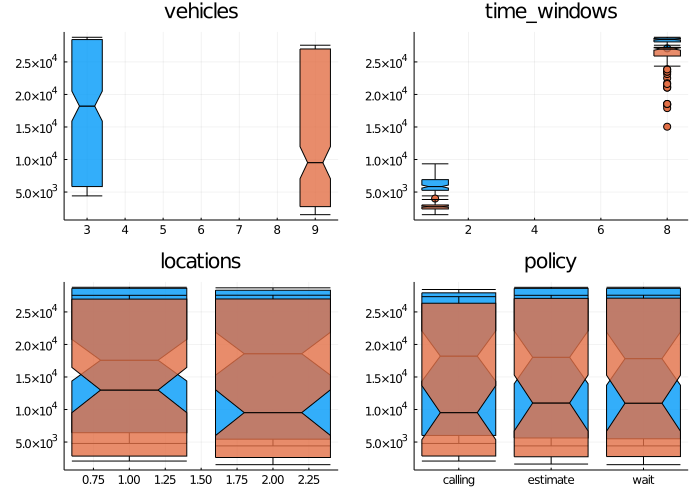

In [28]:
q = @linq df |>
    where(:arrival_type .== "constant") |>
    #by([:vehicles, :time_windows, :locations, :policy], y = mean(:deliveries)) |>
    where(:vehicles .> 0) |>
    where(:time_windows .> 0) |>
    where(:locations .> 0)
a = @df q boxplot(:vehicles, :total_time ./ :vehicles, group=:vehicles, title="vehicles", legend=nothing, notch=true, fillalpha = 0.8)
b = @df q boxplot(:time_windows, :total_time ./ :vehicles, group=:vehicles, title="time_windows", legend=nothing, notch=true, fillalpha = 0.8)
c = @df q boxplot(:locations, :total_time ./ :vehicles, group=:vehicles, title="locations", legend=nothing, notch=true, fillalpha = 0.8)
d = @df q boxplot(:policy, :total_time ./ :vehicles,group=:vehicles, title="policy", legend=nothing, notch=true, fillalpha = 0.8)
plot(a,b,c,d)

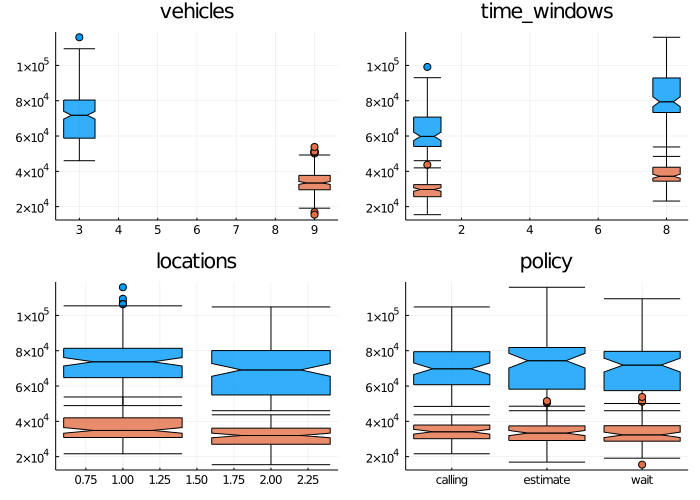

In [29]:
q = @linq df |>
    where(:arrival_type .== "constant") |>
    #by([:vehicles, :time_windows, :locations, :policy], y = mean(:deliveries)) |>
    where(:vehicles .> 0) |>
    where(:time_windows .> 0) |>
    where(:locations .> 0)
a = @df q boxplot(:vehicles, :total_distance ./ :vehicles, group=:vehicles, title="vehicles", legend=nothing, notch=true, fillalpha = 0.8)
b = @df q boxplot(:time_windows, :total_distance ./ :vehicles, group=:vehicles, title="time_windows", legend=nothing, notch=true, fillalpha = 0.8)
c = @df q boxplot(:locations, :total_distance ./ :vehicles, group=:vehicles, title="locations", legend=nothing, notch=true, fillalpha = 0.8)
d = @df q boxplot(:policy, :total_distance ./ :vehicles,group=:vehicles, title="policy", legend=nothing, notch=true, fillalpha = 0.8)
plot(a,b,c,d)

In [31]:
m = lm(@formula(total_distance ~ vehicles), df)
m

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

total_distance ~ 1 + vehicles

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                       Coef.  Std. Error      t  Pr(>|t|)        Lower 95%       Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)        2.23945e6    106938.0  20.94    <1e-79        2.02959e6       2.44931e6
vehicles     -124394.0           15941.3  -7.80    <1e-13  -155678.0        -93109.7
──────────────────────────────────────────────────────────────────────────────────────────